In [ ]:
import glob
import logging
from pathlib import Path

import arviz as az
import numpy as np
import pymc as pm
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sqlalchemy import create_engine

from src.clustering import preproc_features
from src.config import ConfigManager
from src.database import (
    apply_dic_filters,
    get_dic_analysis_ids,
    get_dic_data,
    get_image,
)
from src.roi import PolygonROISelector, filter_dataframe

%config InlineBackend.figure_format = 'retina'
%matplotlib widget
az.style.use("arviz-darkgrid")
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
)

# Load configuration
config = ConfigManager()
db_engine = create_engine(config.db_url)

# Parameters
target_date = "2024-09-02"
camera_name = "PPCX_Tele"
base_output_dir = "output"

In [ ]:
# === DATA EXTRACTION ===

# Build output directory
output_dir = Path(base_output_dir) / camera_name
output_dir.mkdir(parents=True, exist_ok=True)
base_name = f"{camera_name}_{target_date}_PyMC_GMM"

# Get DIC analysis metadata
dic_analyses = get_dic_analysis_ids(
    db_engine, reference_date=target_date, camera_name=camera_name
)
print(f"Found {len(dic_analyses)} DIC analyses")

# Get master image
master_image_id = dic_analyses["master_image_id"].iloc[0]
img = get_image(master_image_id, camera_name=camera_name)

# Fetch displacement data
dic_id = dic_analyses["dic_id"].iloc[0]
df = get_dic_data(
    dic_id,
    app_host=config.get("api.host"),
    app_port=config.get("api.port"),
)

# Apply filters
df = apply_dic_filters(
    df,
    filter_outliers=config.get("dic.filter_outliers"),
    tails_percentile=config.get("dic.tails_percentile"),
    min_velocity=config.get("dic.min_velocity"),
    apply_2d_median=config.get("dic.apply_2d_median"),
    median_window_size=config.get("dic.median_window_size"),
    median_threshold_factor=config.get("dic.median_threshold_factor"),
)

# Apply ROI filter
selector = PolygonROISelector.from_file(config.get("data.roi_path"))
df = filter_dataframe(df, selector.polygon_path, x_col="x", y_col="y")
print(f"Data shape after filtering: {df.shape}")

# === FEATURE PREPARATION ===

# Get clustering parameters from config
variables_names = config.get("clustering.variables_names")
print(f"Using features: {variables_names}")

# Preprocess features
df_features = preproc_features(df)
X = df_features[variables_names].values
n_features = X.shape[1]
ndata = X.shape[0]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"Feature matrix shape: {X_scaled.shape}")

Found 1 DIC analyses


2025-07-29 15:29:23,391 - INFO - Starting DIC filtering pipeline with 5251 points
2025-07-29 15:29:23,393 - INFO - Percentile filtering: 5251 -> 5146 points (removed 105 outliers)
2025-07-29 15:29:23,395 - INFO - Min velocity filtering: 5146 -> 3709 points (removed 1437 points below 1)
2025-07-29 15:29:23,395 - INFO - Applying 2D median filter: window_size=5, threshold_factor=3.0
2025-07-29 15:29:23,400 - INFO - Estimated grid spacing: 64.00
2025-07-29 15:29:23,560 - INFO - Created 2D grid: (82, 59), 3709 valid points
2025-07-29 15:29:23,564 - INFO - Detected 411 outliers in 2D median filter
2025-07-29 15:29:23,712 - INFO - 2D median filtering: 3709 -> 3298 points (removed 411 outliers)
2025-07-29 15:29:23,713 - INFO - DIC filtering pipeline completed: 5251 -> 3298 points (removed 1953 total)


Filtered 3298 points to 2070 points inside polygon
Data shape after filtering: (2070, 5)
Using features: ['V', 'angle_deg']
Feature matrix shape: (2070, 2)


Found 4 sector polygons for priors
Sector 0: 204 points with strong prior
Sector 1: 328 points with strong prior
Sector 2: 381 points with strong prior
Sector 3: 1030 points with strong prior


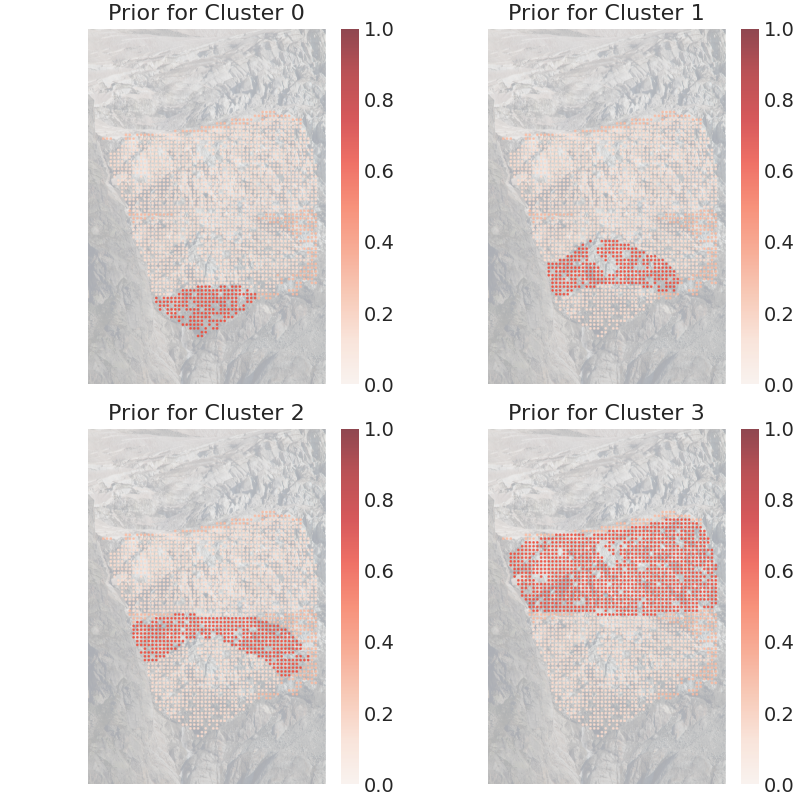

In [5]:
# === SPATIAL PRIOR SETUP ===
def assign_spatial_priors_dic(df, selectors, prior_strength=0.8):
    """Assign spatial prior probabilities based on polygon sectors."""
    ndata = len(df)
    k = len(selectors)
    prior_probs = np.ones((ndata, k)) / k  # default uniform

    for idx, selector in enumerate(selectors):
        mask = selector.contains_points(df["x"].values, df["y"].values)
        # Strong prior for points inside polygon
        prior_probs[mask] = (1 - prior_strength) / (
            k - 1
        )  # small prob for other clusters
        prior_probs[mask, idx] = prior_strength  # high prob for this cluster
        print(f"Sector {idx}: {mask.sum()} points with strong prior")

    return prior_probs


# Load sector polygons for priors
sector_files = sorted(glob.glob("data/sectors_prior/*.json"))
sector_selectors = [PolygonROISelector.from_file(f) for f in sector_files]
k = len(sector_selectors)  # number of clusters = number of sectors
print(f"Found {k} sector polygons for priors")

# Assign priors
prior_strength = 0.6
prior_probs = assign_spatial_priors_dic(
    df, sector_selectors, prior_strength=prior_strength
)

# Visualize priors
nrows = int(np.ceil(np.sqrt(k)))
ncols = int(np.ceil(k / nrows))
fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))
axes = [axes] if k == 1 else axes.flatten()
for cluster in range(k):
    axes[cluster].imshow(img, alpha=0.3)
    scatter = axes[cluster].scatter(
        df["x"],
        df["y"],
        c=prior_probs[:, cluster],
        cmap="Reds",
        s=1,
        alpha=0.7,
        vmin=0,
        vmax=1,
    )
    axes[cluster].set_title(f"Prior for Cluster {cluster}")
    axes[cluster].xaxis.set_ticks([])
    axes[cluster].yaxis.set_ticks([])
    plt.colorbar(scatter, ax=axes[cluster])

plt.show()

Model with spatial priors created


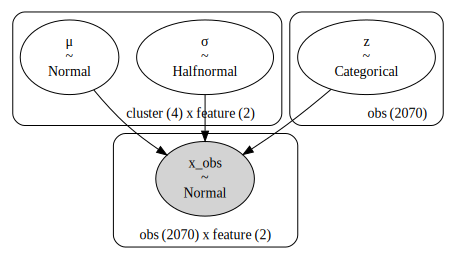

In [6]:
# === PYMC MODEL WITH SPATIAL PRIORS ===
with pm.Model(
    coords={"cluster": range(k), "feature": range(n_features), "obs": range(ndata)}
) as model_with_priors:
    # Cluster means (multivariate)
    μ = pm.Normal("μ", mu=0, sigma=3, dims=("cluster", "feature"))

    # Cluster standard deviations (diagonal covariance)
    σ = pm.HalfNormal("σ", sigma=2, dims=("cluster", "feature"))

    # Cluster assignments with spatial priors
    z = pm.Categorical("z", p=prior_probs, dims="obs")

    # Likelihood: each point comes from its assigned cluster
    pm.Normal("x_obs", mu=μ[z], sigma=σ[z], observed=X_scaled, dims=("obs", "feature"))

print("Model with spatial priors created")
pm.model_to_graphviz(model_with_priors)

In [ ]:
# === SAMPLE FROM MODEL ===
with model_with_priors:
    print("Starting MCMC sampling...")
    idata_with_priors = pm.sample(
        draws=1000, tune=1000, target_accept=0.85, random_seed=RANDOM_SEED
    )

print("Sampling completed!")

Starting MCMC sampling...


Multiprocess sampling (4 chains in 4 jobs)
2025-07-29 15:34:49,089 - INFO - Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
2025-07-29 15:34:49,090 - INFO - CompoundStep
>NUTS: [μ, σ]
2025-07-29 15:34:49,091 - INFO - >NUTS: [μ, σ]
>CategoricalGibbsMetropolis: [z]
2025-07-29 15:34:49,091 - INFO - >CategoricalGibbsMetropolis: [z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1022 seconds.
2025-07-29 15:51:50,958 - INFO - Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1022 seconds.
/home/francesco/ppcx/ppcx-domains/.venv/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
2025-07-29 15:51:56,120 - INFO - The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.080

Sampling completed!


In [14]:
az.rhat(idata_with_priors)

<xarray.Dataset> Size: 33kB
Dimensions:  (cluster: 4, feature: 2, obs: 2070)
Coordinates:
  * cluster  (cluster) int64 32B 0 1 2 3
  * feature  (feature) int64 16B 0 1
  * obs      (obs) int64 17kB 0 1 2 3 4 5 6 ... 2064 2065 2066 2067 2068 2069
Data variables:
    μ        (cluster, feature) float64 64B 1.003 1.002 1.012 ... 1.008 1.003
    z        (obs) float64 17kB 1.003 0.9998 1.002 1.003 ... 1.007 1.005 1.001
    σ        (cluster, feature) float64 64B 1.002 1.001 1.004 ... 1.003 1.007

In [ ]:
# Check R-hat (should be < 1.01)
print(az.rhat(idata_with_priors))

/home/francesco/ppcx/ppcx-domains/.venv/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


<xarray.Dataset> Size: 33kB
Dimensions:  (cluster: 4, feature: 2, obs: 2070)
Coordinates:
  * cluster  (cluster) int64 32B 0 1 2 3
  * feature  (feature) int64 16B 0 1
  * obs      (obs) int64 17kB 0 1 2 3 4 5 6 ... 2064 2065 2066 2067 2068 2069
Data variables:
    μ        (cluster, feature) float64 64B 1.003 1.002 1.012 ... 1.008 1.003
    z        (obs) float64 17kB 1.003 0.9998 1.002 1.003 ... 1.007 1.005 1.001
    σ        (cluster, feature) float64 64B 1.002 1.001 1.004 ... 1.003 1.007


In [12]:
# Check effective sample size (should be > 100)
print(az.ess(idata_with_priors))

<xarray.Dataset> Size: 33kB
Dimensions:  (cluster: 4, feature: 2, obs: 2070)
Coordinates:
  * cluster  (cluster) int64 32B 0 1 2 3
  * feature  (feature) int64 16B 0 1
  * obs      (obs) int64 17kB 0 1 2 3 4 5 6 ... 2064 2065 2066 2067 2068 2069
Data variables:
    μ        (cluster, feature) float64 64B 574.0 1.431e+03 ... 461.6 657.8
    z        (obs) float64 17kB 1.44e+03 1.278e+03 1.636e+03 ... 813.3 1.256e+03
    σ        (cluster, feature) float64 64B 1.7e+03 1.708e+03 ... 571.8 305.7


In [19]:
idata_with_priors


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

array([[<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>]],
      dtype=object)

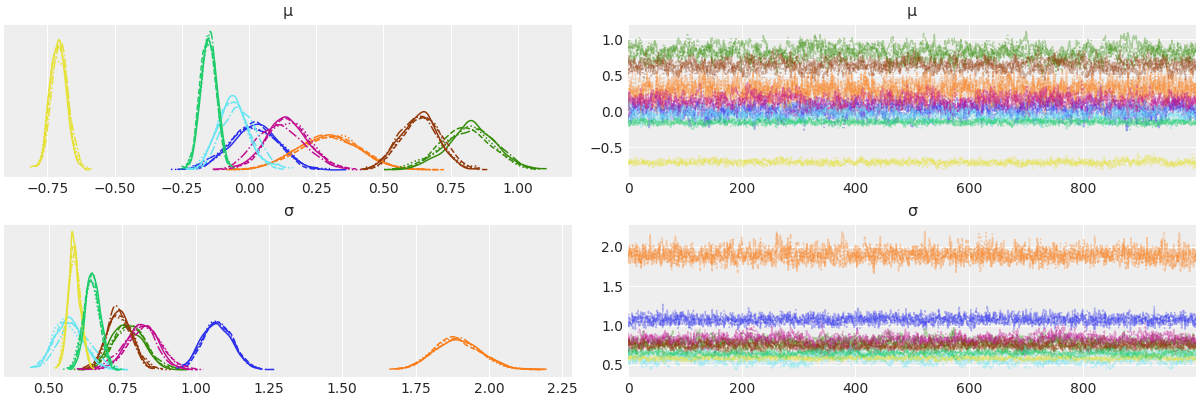

In [17]:
# Plot trace plots
az.plot_trace(idata_with_priors, var_names=["μ", "σ"])


In [ ]:
idata_with_priors


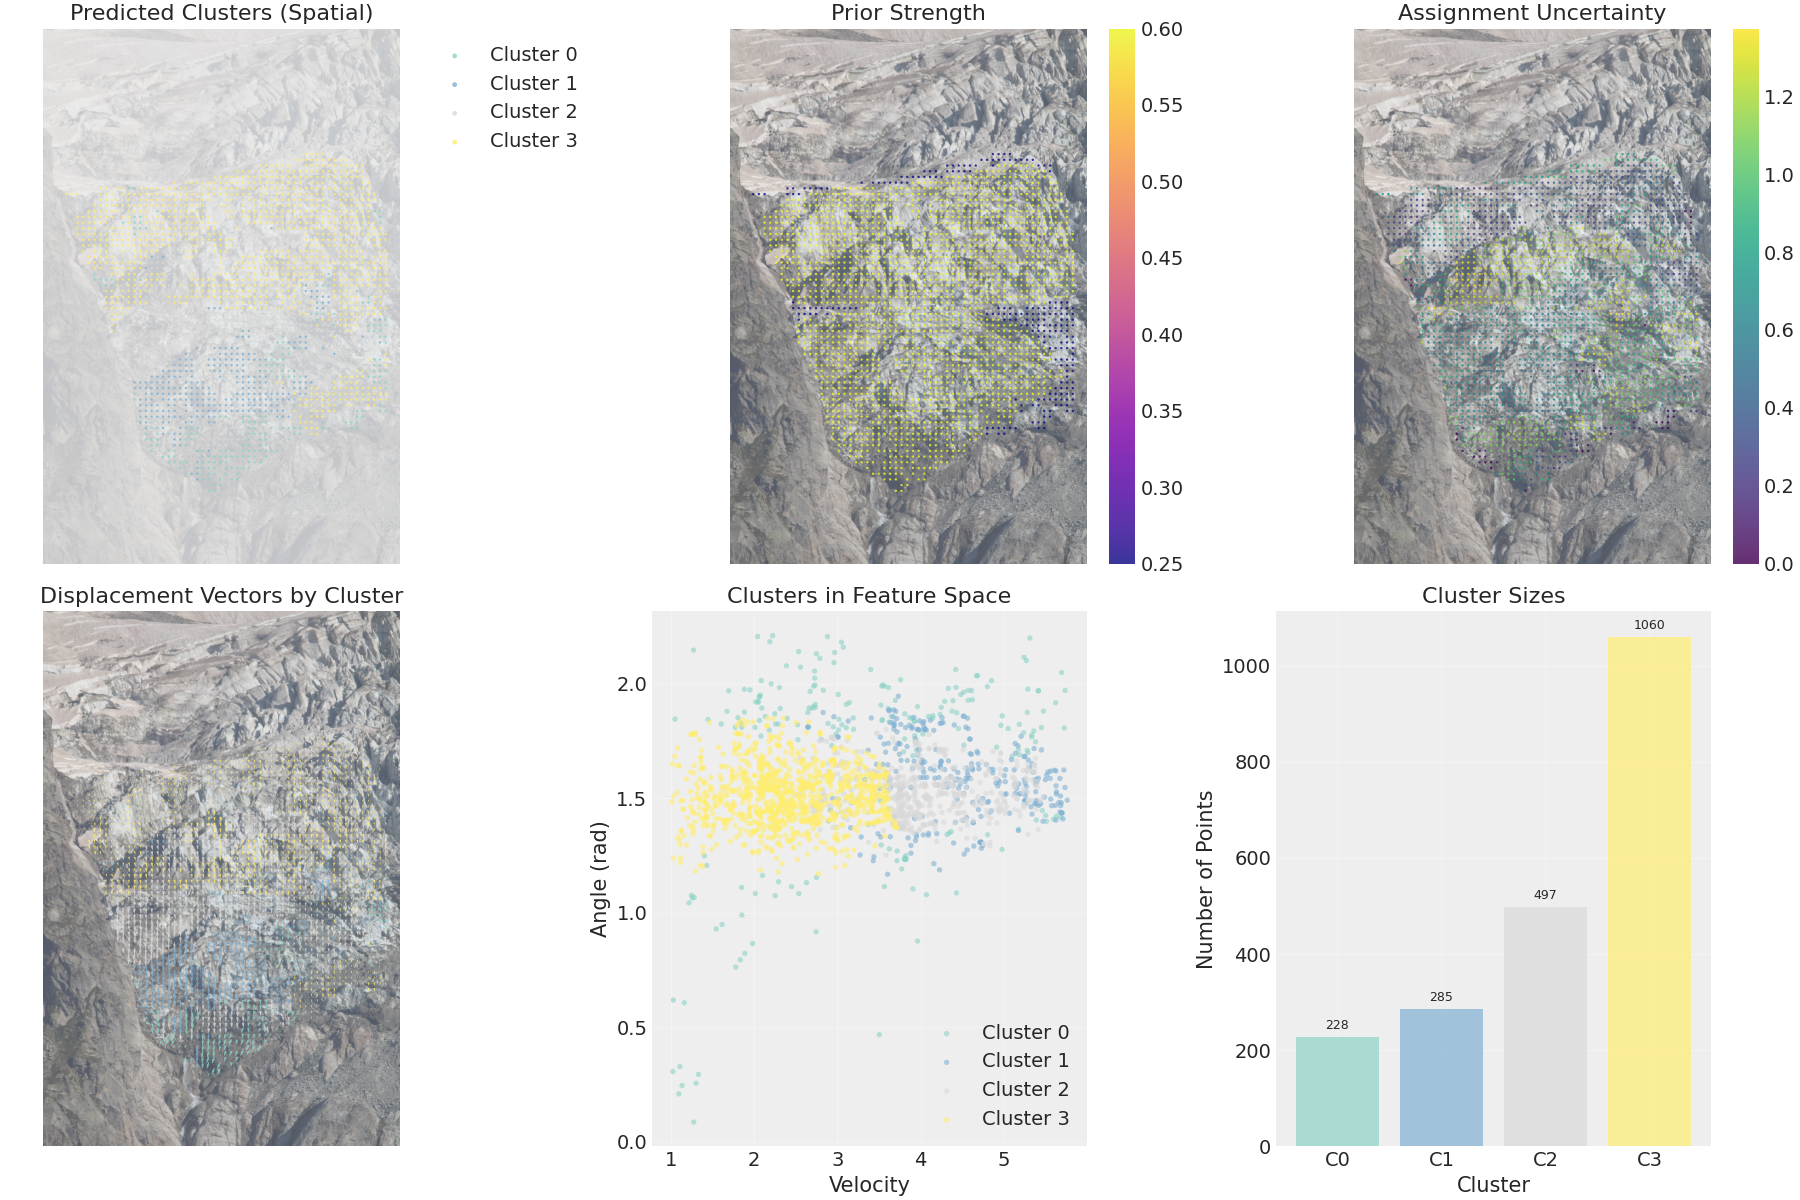

In [20]:
def plot_dic_mixture_results(
    df_features, X_scaled, idata, prior_probs, img, variables_names
):
    """Plot DIC clustering results with uncertainty overlaid on background image."""

    # Get posterior cluster assignments
    z_posterior = idata.posterior["z"]

    # Most likely cluster for each point
    z_samples = z_posterior.values
    z_flat = z_samples.reshape(-1, z_samples.shape[-1])

    cluster_pred = np.zeros(z_samples.shape[-1], dtype=int)
    for i in range(z_samples.shape[-1]):
        values, counts = np.unique(z_flat[:, i], return_counts=True)
        cluster_pred[i] = values[np.argmax(counts)]

    # Assignment probabilities
    z_probs = np.stack(
        [
            (z_posterior == k).mean(dim=["chain", "draw"]).values
            for k in range(len(sector_selectors))
        ],
        axis=1,
    )

    # Uncertainty (entropy)
    uncertainty = -np.sum(z_probs * np.log(z_probs + 1e-10), axis=1)

    # Create comprehensive plot
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Get unique labels and create colors (like in plot_gmm_clusters)
    unique_labels = np.unique(cluster_pred)
    n_clusters = len(unique_labels)

    if n_clusters > 0:
        cmap = plt.get_cmap("Set3")
        colors = cmap(np.linspace(0, 1, max(n_clusters, 3)))
        color_map = {
            label: colors[i % len(colors)] for i, label in enumerate(unique_labels)
        }
    else:
        color_map = {}

    # Row 1: Spatial plots with image overlay
    # Plot 1: Cluster assignments overlaid on image
    ax1 = axes[0, 0]
    if img is not None:
        ax1.imshow(img, alpha=0.2)

    for label in unique_labels:
        mask = cluster_pred == label
        if np.any(mask):
            ax1.scatter(
                df_features.loc[mask, "x"],
                df_features.loc[mask, "y"],
                c=[color_map[label]],
                s=3,
                alpha=0.8,
                label=f"Cluster {label}",
                edgecolors="none",
            )

    ax1.set_title("Predicted Clusters (Spatial)")
    ax1.legend(bbox_to_anchor=(1.05, 1), loc="upper left", markerscale=2)
    ax1.set_aspect("equal")
    ax1.grid(False)
    ax1.set_xlabel("")
    ax1.set_ylabel("")
    ax1.set_xticks([])
    ax1.set_yticks([])

    # Plot 2: Prior strength overlaid on image
    ax2 = axes[0, 1]
    if img is not None:
        ax2.imshow(img, alpha=0.7)

    max_prior = np.max(prior_probs, axis=1)
    scatter2 = ax2.scatter(
        df_features["x"],
        df_features["y"],
        c=max_prior,
        cmap="plasma",
        s=3,
        alpha=0.8,
        edgecolors="none",
    )
    ax2.set_title("Prior Strength")
    ax2.set_aspect("equal")
    ax2.grid(False)
    ax2.set_xlabel("")
    ax2.set_ylabel("")
    ax2.set_xticks([])
    ax2.set_yticks([])
    plt.colorbar(scatter2, ax=ax2)

    # Plot 3: Assignment uncertainty overlaid on image
    ax3 = axes[0, 2]
    if img is not None:
        ax3.imshow(img, alpha=0.7)

    scatter3 = ax3.scatter(
        df_features["x"],
        df_features["y"],
        c=uncertainty,
        cmap="viridis",
        s=3,
        alpha=0.8,
        edgecolors="none",
    )
    ax3.set_title("Assignment Uncertainty")
    ax3.set_aspect("equal")
    ax3.grid(False)
    ax3.set_xlabel("")
    ax3.set_ylabel("")
    ax3.set_xticks([])
    ax3.set_yticks([])
    plt.colorbar(scatter3, ax=ax3)

    # Row 2: Feature space plots and displacement vectors
    # Plot 4: Displacement vectors colored by clusters (like plot_gmm_clusters)
    ax4 = axes[1, 0]
    if img is not None:
        ax4.imshow(img, alpha=0.7)

    # Create a colormap for the quiver plot based on clusters
    cluster_colors = np.array([color_map[label] for label in cluster_pred])

    # Plot displacement vectors
    q = ax4.quiver(
        df_features["x"],
        df_features["y"],
        df_features["u"],
        df_features["v"],
        scale=None,
        scale_units="xy",
        angles="xy",
        color=cluster_colors,  # Color by cluster
        width=0.003,
        headwidth=2.5,
        alpha=0.8,
    )
    ax4.set_title("Displacement Vectors by Cluster")
    ax4.set_aspect("equal")
    ax4.grid(False)
    ax4.set_xlabel("")
    ax4.set_ylabel("")
    ax4.set_xticks([])
    ax4.set_yticks([])

    # Plot 5: Feature space plot (V vs angle if available)
    ax5 = axes[1, 1]
    if "V" in df_features.columns and "angle_rad" in df_features.columns:
        for label in unique_labels:
            mask = cluster_pred == label
            if np.any(mask):
                ax5.scatter(
                    df_features.loc[mask, "V"],
                    df_features.loc[mask, "angle_rad"],
                    c=[color_map[label]],
                    s=15,
                    alpha=0.6,
                    label=f"Cluster {label}",
                    edgecolors="none",
                )
        ax5.set_title("Clusters in Feature Space")
        ax5.set_xlabel("Velocity")
        ax5.set_ylabel("Angle (rad)")
        ax5.legend()
    else:
        # Use first two features if V and angle_rad not available
        feat1, feat2 = (
            variables_names[0],
            variables_names[1] if len(variables_names) > 1 else variables_names[0],
        )
        for label in unique_labels:
            mask = cluster_pred == label
            if np.any(mask):
                ax5.scatter(
                    df_features.loc[mask, feat1],
                    df_features.loc[mask, feat2],
                    c=[color_map[label]],
                    s=15,
                    alpha=0.6,
                    label=f"Cluster {label}",
                    edgecolors="none",
                )
        ax5.set_title(f"Clusters: {feat1} vs {feat2}")
        ax5.set_xlabel(feat1)
        ax5.set_ylabel(feat2)
        ax5.legend()

    ax5.grid(True, alpha=0.3)

    # Plot 6: Cluster statistics (like in plot_gmm_clusters)
    ax6 = axes[1, 2]
    cluster_stats = []
    for label in unique_labels:
        mask = cluster_pred == label
        count = mask.sum()
        avg_uncertainty = uncertainty[mask].mean() if count > 0 else 0
        avg_velocity = (
            df_features.loc[mask, "V"].mean()
            if count > 0 and "V" in df_features.columns
            else 0
        )

        cluster_stats.append(
            {
                "label": label,
                "count": count,
                "avg_uncertainty": avg_uncertainty,
                "avg_velocity": avg_velocity,
            }
        )

    # Bar plot of cluster sizes
    labels_list = [stat["label"] for stat in cluster_stats]
    counts = [stat["count"] for stat in cluster_stats]
    colors_list = [color_map[label] for label in labels_list]

    bars = ax6.bar(range(len(cluster_stats)), counts, color=colors_list, alpha=0.7)
    ax6.set_title("Cluster Sizes")
    ax6.set_xlabel("Cluster")
    ax6.set_ylabel("Number of Points")
    ax6.set_xticks(range(len(cluster_stats)))
    ax6.set_xticklabels([f"C{label}" for label in labels_list])
    ax6.grid(True, alpha=0.3)

    # Add count labels on bars
    for bar, count in zip(bars, counts, strict=False):
        height = bar.get_height()
        ax6.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + max(counts) * 0.01,
            f"{count}",
            ha="center",
            va="bottom",
            fontsize=9,
        )

    return cluster_pred, z_probs, uncertainty


# Generate results
cluster_pred, z_probs, uncertainty = plot_dic_mixture_results(
    df_features, X_scaled, idata_with_priors, prior_probs, img, variables_names
)

# Save results
fig = plt.gcf()
fig.savefig(output_dir / f"{base_name}_results.png", dpi=300, bbox_inches="tight")

In [ ]:
# === RESULTS ANALYSIS ===


def plot_dic_mixture_results(
    df_features, X_scaled, idata, prior_probs, img, variables_names
):
    """Plot DIC clustering results with uncertainty."""

    # Get posterior cluster assignments
    z_posterior = idata.posterior["z"]

    # Most likely cluster for each point
    z_samples = z_posterior.values
    z_flat = z_samples.reshape(-1, z_samples.shape[-1])

    cluster_pred = np.zeros(z_samples.shape[-1], dtype=int)
    for i in range(z_samples.shape[-1]):
        values, counts = np.unique(z_flat[:, i], return_counts=True)
        cluster_pred[i] = values[np.argmax(counts)]

    # Assignment probabilities
    z_probs = np.stack(
        [
            (z_posterior == k).mean(dim=["chain", "draw"]).values
            for k in range(len(sector_selectors))
        ],
        axis=1,
    )

    # Uncertainty (entropy)
    uncertainty = -np.sum(z_probs * np.log(z_probs + 1e-10), axis=1)

    # Create comprehensive plot
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Row 1: Spatial plots
    # Plot 1: Cluster assignments in space
    scatter1 = axes[0, 0].scatter(
        df_features["x"], df_features["y"], c=cluster_pred, cmap="tab10", s=1, alpha=0.7
    )
    axes[0, 0].set_title("Predicted Clusters (Spatial)")
    axes[0, 0].set_xlabel("X")
    axes[0, 0].set_ylabel("Y")

    # Plot 2: Prior strength
    max_prior = np.max(prior_probs, axis=1)
    scatter2 = axes[0, 1].scatter(
        df_features["x"], df_features["y"], c=max_prior, cmap="plasma", s=1, alpha=0.7
    )
    axes[0, 1].set_title("Prior Strength")
    axes[0, 1].set_xlabel("X")
    axes[0, 1].set_ylabel("Y")
    plt.colorbar(scatter2, ax=axes[0, 1])

    # Plot 3: Assignment uncertainty
    scatter3 = axes[0, 2].scatter(
        df_features["x"],
        df_features["y"],
        c=uncertainty,
        cmap="viridis",
        s=1,
        alpha=0.7,
    )
    axes[0, 2].set_title("Assignment Uncertainty")
    axes[0, 2].set_xlabel("X")
    axes[0, 2].set_ylabel("Y")
    plt.colorbar(scatter3, ax=axes[0, 2])

    # Row 2: Feature space plots (if we have velocity and angle)
    if "V" in df_features.columns and "angle_rad" in df_features.columns:
        # Plot feature space clusters
        scatter4 = axes[1, 0].scatter(
            df_features["V"],
            df_features["angle_rad"],
            c=cluster_pred,
            cmap="tab10",
            s=1,
            alpha=0.7,
        )
        axes[1, 0].set_title("Clusters in Feature Space")
        axes[1, 0].set_xlabel("Velocity")
        axes[1, 0].set_ylabel("Angle (rad)")

        scatter5 = axes[1, 1].scatter(
            df_features["V"],
            df_features["angle_rad"],
            c=uncertainty,
            cmap="viridis",
            s=1,
            alpha=0.7,
        )
        axes[1, 1].set_title("Uncertainty in Feature Space")
        axes[1, 1].set_xlabel("Velocity")
        axes[1, 1].set_ylabel("Angle (rad)")
        plt.colorbar(scatter5, ax=axes[1, 1])
    else:
        # Use first two features if V and angle_rad not available
        feat1, feat2 = (
            variables_names[0],
            variables_names[1] if len(variables_names) > 1 else variables_names[0],
        )
        scatter4 = axes[1, 0].scatter(
            df_features[feat1],
            df_features[feat2],
            c=cluster_pred,
            cmap="tab10",
            s=1,
            alpha=0.7,
        )
        axes[1, 0].set_title(f"Clusters: {feat1} vs {feat2}")
        axes[1, 0].set_xlabel(feat1)
        axes[1, 0].set_ylabel(feat2)

    # Cluster statistics
    axes[1, 2].axis("off")
    cluster_stats = []
    for i in range(len(sector_selectors)):
        mask = cluster_pred == i
        count = mask.sum()
        avg_uncertainty = uncertainty[mask].mean() if count > 0 else 0
        cluster_stats.append(
            f"Cluster {i}: {count} points, avg uncertainty: {avg_uncertainty:.3f}"
        )

    axes[1, 2].text(
        0.1,
        0.9,
        "Cluster Statistics:",
        fontsize=12,
        fontweight="bold",
        transform=axes[1, 2].transAxes,
    )
    for i, stat in enumerate(cluster_stats):
        axes[1, 2].text(
            0.1, 0.8 - i * 0.1, stat, fontsize=10, transform=axes[1, 2].transAxes
        )

    return cluster_pred, z_probs, uncertainty


# Generate results
cluster_pred, z_probs, uncertainty = plot_dic_mixture_results(
    df_features, X_scaled, idata_with_priors, prior_probs, img, variables_names
)

# Save results
fig = plt.gcf()
fig.savefig(output_dir / f"{base_name}_results.png", dpi=300, bbox_inches="tight")
